In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
def compute_bellow_moment_force(p, R_outer, r_inner, n_bellow):
    """Approximate the total force and moment from the bellow structure. Approximate bellow
    structure area.

    Args:
        p (float): Pressure in Pa
        R_outer (float): Outer radius of the bellow in mm
        r_inner (float): Inner radius of the bellow in mm
        n_bellow (np.array): Number of bellows in the structure
    """
    # Reshape n_bellow to column vector
    n_bellow = n_bellow.reshape(-1, 1)
    # Effective area of a single bellow - hollow semicircle with radius R_outer and r_inner
    A_bellow = np.pi * (R_outer**2 - r_inner**2) / 2
    # Total force from bellow structure
    F_bellow = n_bellow * p * A_bellow
    # Total moment from bellow structure
    M_bellow = 2/3 * n_bellow * p * (R_outer**3 - r_inner**3)

    return A_bellow, F_bellow, M_bellow

def calculate_stiffness_hollow_semicircular_annulus_thick(L, E, R_out, r_in, t):
    ###### Fourth set of equations corresponds to Hollow semicircular annulus with 
    # thickened rectangular element below

    # Area of the semicirular annulus
    A_semi = np.pi * (R_out**2 - r_in**2) / 2
    # Area of the rectangular base width 2R_out and height t
    A_rect = 2 * R_out * t

    # Area moment of inertia of the semicircular annulus
    I_semi = np.pi / 8 * (R_out**4 - r_in**4)
    # Area moment of inertia of the rectangular base
    I_rect_centroid = 1/12 * 2 * R_out * t**3
    # Parallel axis theorem to calculate I_rect about upper edge (base)
    I_rect = I_rect_centroid + A_rect * (t / 2)**2
    # Total area moment of inertia
    I_total = I_semi + I_rect

    # Stifness - in L direction for elongation E * A / L
    Cz = E / L * (A_semi + A_rect) # F / delta_x

    # Rotational stiffness
    # Ky = E / L * (np.pi / 8 * (R_out**4 - r_in**4) + 2 / 3 * R_out * t**3)  # M / delta_theta_y
    Ky = E / L * I_total # M / delta_theta_y

    return A_semi, A_rect, I_semi, I_rect, I_total, Cz, Ky


#### Optimizazion of PRB model - END MOMENT LOADING

In [46]:
# Parametric angle coefficient
c_theta = 1.5164
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three bellow segments in mm
L0 = np.array([31, 21, 21])
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_bellow_out = 22
d_bellow_in = 7.85
# Thickness of bottom layer in mm
t = (2.5 + 4.7) / 2

pressure = np.linspace(0, 0.7, 8)  # Internal pressure (MPa)
# Remove thickness of the bellow from R_outer, and add it to r_inner (+0.9 due to geometry)
R_outer = 15.5 - 0.8  # Outer diameter of bellow (mm) - 15.5 is from thick element to top
r_inner = d_bellow_in + 0.575  # Inner diameter of bellow (mm)
n_bellow = np.array([7, 5, 5])  # Number of bellows

# Load experimental data
experiment_data = pd.read_csv('kinematics/Hand9DOF/Index/data/soft_robot_experiment_results.csv')
# Extract only index finger delta_z exparimental
delta_z_exp = experiment_data[experiment_data['finger'] == 'index'].dropna()[['d_1_3', 'd_3_5', 'd_5_7']].values.T
delta_theta_y_exp_rep1 = experiment_data.loc[(experiment_data['finger'] == 'index') & (experiment_data['rep'] == 1)][['theta2', 'theta4', 'theta6']].values.T
delta_theta_y_exp_rep2 = experiment_data.loc[(experiment_data['finger'] == 'index') & (experiment_data['rep'] == 2)][['theta2', 'theta4', 'theta6']].values.T

def compute_angle_displacement_nrmse(
    lmbd, gamma, pressure, R_outer, r_inner, n_bellow, L0, E, d_hole, D_bellow_out, d_bellow_in, t,
    c_theta, delta_z_exp, delta_theta_y_exp_rep1, delta_theta_y_exp_rep2
    ):
    # Compute single bellow area, force and moment
    A_bellow, F_bellow, M_bellow = compute_bellow_moment_force(
        pressure*gamma, R_outer, r_inner, n_bellow
        )
    # Calculate equivalent diameter
    D_bellow_out_equivalent = lmbd * D_bellow_out + (1 - lmbd) * d_bellow_in
    # Calculate stiffness
    _, _, _, _, I_total, Cz, _ = calculate_stiffness_hollow_semicircular_annulus_thick(
        L0, E, D_bellow_out_equivalent / 2, d_hole / 2, t
        )
    # Compute elongation
    delta_z = F_bellow / Cz[:, np.newaxis] 
    # Torsional spring constant - for end moment gamma_pivot * K_theta = c_theta
    K = c_theta * E * I_total / L0
    # Calculate pivot angle
    delta_theta_pivot = M_bellow / K[:, np.newaxis]
    # Calculate angle displacement
    delta_theta_y = delta_theta_pivot * c_theta * 180 / np.pi
    # Calculate sd normalized root mean square errors
    delta_z_rmse = np.sqrt(np.mean(np.square(delta_z_exp - delta_z)))
    delta_z_nrmse = delta_z_rmse / delta_z_exp.std()
    delta_theta_y_rmse_rep1 = np.sqrt(np.mean(np.square(delta_theta_y_exp_rep1 - delta_theta_y)))
    delta_theta_y_rmse_rep2 = np.sqrt(np.mean(np.square(delta_theta_y_exp_rep2 - delta_theta_y)))
    delta_theta_y_nrmse_rep1 = delta_theta_y_rmse_rep1 / delta_theta_y_exp_rep1.std()
    delta_theta_y_nrmse_rep2 = delta_theta_y_rmse_rep2 / delta_theta_y_exp_rep2.std()
    return delta_z_nrmse, (delta_theta_y_nrmse_rep1 + delta_theta_y_nrmse_rep2) / 2

def obj_func_single_param(x):
    # print(x)
    lmbd = x[[0, 1, 1]]
    gamma = x[2:].reshape(-1, 1)
    delta_z_nrmse, delta_theta_y_nrmse = compute_angle_displacement_nrmse(
        lmbd, gamma, pressure, R_outer, r_inner, n_bellow, L0, E, d_hole, D_bellow_out, d_bellow_in, t,
        c_theta, delta_z_exp, delta_theta_y_exp_rep1, delta_theta_y_exp_rep2
        )
    return (delta_z_nrmse + delta_theta_y_nrmse) / 2

obj_func_single_param(np.array([0.65, 0.65, 1.0, 1.0, 1.0]))


optim_res = scipy.optimize.brute(
    func=obj_func_single_param,
    ranges=(
        # lambda range from 0.2 to 0.9 with step 0.05,
        slice(0.5, 0.98, 0.05), slice(0.5, 0.9, 0.05),
        # gamma from 0.6 to 1.4 with step 0.05
        slice(0.1, 1.0, 0.05), slice(0.1, 1.0, 0.05), slice(0.1, 1.0, 0.05)),
    full_output=True,
    # finish=None,
    finish=scipy.optimize.fmin,
    workers=-1
    )
# Plot only parameters and objective function value
optim_res[:2]

(array([1.32207878, 1.33774712, 1.41847906, 2.79471008, 3.51588913]),
 0.21620713608372805)

In [50]:
print(f'Grid minimum NRMSE: {optim_res[3].min()}')
min_ind = np.unravel_index(optim_res[3].argmin(), optim_res[3].shape)

Grid minimum NRMSE: 0.5773547291905063


In [51]:
print(f'Grid optimal params: {optim_res[2][(slice(None),) + min_ind]}')

Grid optimal params: [0.95 0.8  0.65 0.8  0.95]


#### Hollow Semicircular Annulus and rectangular base

In [6]:
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three bellow segments in mm
L0 = np.array([31, 21, 21])
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_bellow_out = 22
d_bellow_in = 7.85
# Thickness of bottom layer in mm - use average of min and max measured
t = 2.5 
# Equivalent diameter to reduce the cross-section surface area - not full material
# Use lmbd as a mixing parameter betweeen D_bellow_out and d_bellow_in
# lmbd = np.array([0.94, 0.74, 0.74]) # Works for maximum pressure of 3 bar
lmbd = np.array([1.17972463, 1.19480546, 1.19480546]) # Works for maximum pressure of 3 bar
# lmbd = 0.65
D_bellow_out_equivalent = lmbd * D_bellow_out + (1 - lmbd) * d_bellow_in

# Area of the semicirular annulus
# Area of the rectangular base width D_bellow_out_equivalent and height t
# Area moment of inertia of the semicircular annulus
# Area moment of inertia of the rectangular base
# Parallel axis theorem to calculate I_rect about upper edge (base)
# Total area moment of inertia
# Rotational stifness about y-axis
A_semi, A_rect, I_semi, I_rect, I_total, Cz, Ky = calculate_stiffness_hollow_semicircular_annulus_thick(
    L0, E, D_bellow_out_equivalent / 2, d_hole / 2, t
    )

# Print all dimensions and design parameters
print("Lengths")
print(f'L0 = {L0} mm')
print('Diameters')
print(f'D_bellow_out = {D_bellow_out} mm')
print(f'd_bellow_in = {d_bellow_in} mm')
print(f'd_hole = {d_hole} mm')
print('Thickness')
print(f't = {t} mm')
print('Equivalent Parameters')
print(f'lambda = {lmbd}')
print(f'D_bellow_out_equivalent = {D_bellow_out_equivalent} mm')
print('Areas')
print(f'A_semi = {A_semi} mm^2')
print(f'A_rect = {A_rect} mm^2')
print('Area moment of inertia')
print(f'I_semi = {I_semi} mm^4')
print(f'I_rect = {I_rect} mm^4')
print(f'I_total = {I_total} mm^4')
print('Material Properties')
print(f'E = {E} MPa')
print("Stiffness")
print(f'Cz = {Cz} N/mm')
print('Rotational Stiffness')
print(f'Ky = {Ky} Nmm/rad')

Lengths
L0 = [31 21 21] mm
Diameters
D_bellow_out = 22 mm
d_bellow_in = 7.85 mm
d_hole = 6 mm
Thickness
t = 1.25 mm
Equivalent Parameters
lambda = [1.17972463 1.19480546 1.19480546]
D_bellow_out_equivalent = [24.54310351 24.75649726 24.75649726] mm
Areas
A_semi = [222.41059527 226.54187852 226.54187852] mm^2
A_rect = [30.67887939 30.94562157 30.94562157] mm^2
Area moment of inertia
I_semi = [8873.68135597 9187.46473512 9187.46473512] mm^4
I_rect = [15.97858302 16.11751124 16.11751124] mm^4
I_total = [8889.65993899 9203.58224635 9203.58224635] mm^4
Material Properties
E = 27 MPa
Stiffness
Cz = [220.43276825 331.05535726 331.05535726] N/mm
Rotational Stiffness
Ky = [ 7742.60704364 11833.17717388 11833.17717388] Nmm/rad


#### Bending moment and axial force approximation from pressure

In [43]:
pressure = np.linspace(0, 0.7, 8)  # Internal pressure (MPa)
# Remove thickness of the bellow from R_outer, and add it to r_inner (+0.9 due to geometry)
R_outer = 15.5 - 0.8  # Outer diameter of bellow (mm) - 15.5 is from thick element to top
r_inner = d_bellow_in + 0.575  # Inner diameter of bellow (mm)
n_bellow = np.array([7, 5, 5])  # Number of bellows
# gamma = np.array([1.36 , 1.44 , 1.96])[:, np.newaxis] # Pressure adjustment
gamma = np.array([2.3369788 , 4.61432697, 5.80510008])[:, np.newaxis] # Pressure adjustment
pressure_adj = pressure * gamma


print(f'pressure p = {pressure} MPa')
print(f'R_outer = {R_outer} mm')
print(f'r_inner = {r_inner} mm')
print(f'n_bellow: {n_bellow}')
A_bellow, F_bellow, M_bellow = compute_bellow_moment_force(pressure_adj, R_outer, r_inner, n_bellow)
print(f"A_bellow = {A_bellow} mm^2")
print('F_bellow [N]')
print(F_bellow)
print("M_bellow [Nmm]")
print(M_bellow)

pressure p = [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7] MPa
R_outer = 14.7 mm
r_inner = 8.424999999999999 mm
n_bellow: [7 5 5]
A_bellow = 227.9372732335032 mm^2
F_bellow [N]
[[   0.          372.87920269  745.75840539 1118.63760808 1491.51681077
  1864.39601347 2237.27521616 2610.15441885]
 [   0.          525.88855367 1051.77710735 1577.66566102 2103.5542147
  2629.44276837 3155.33132205 3681.21987572]
 [   0.          661.59934154 1323.19868308 1984.79802462 2646.39736617
  3307.99670771 3969.59604925 4631.19539079]]
M_bellow [Nmm]
[[    0.          2812.09884214  5624.19768428  8436.29652641
  11248.39536855 14060.49421069 16872.59305283 19684.69189497]
 [    0.          3966.03131041  7932.06262082 11898.09393122
  15864.12524163 19830.15655204 23796.18786245 27762.21917286]
 [    0.          4989.50525765  9979.0105153  14968.51577295
  19958.0210306  24947.52628825 29937.0315459  34926.53680355]]


#### Pseudo-Rigid-Body Models for Planar Beams - END-MOMENT LOADING

[11740.88932097 17943.82986647 17943.82986647]


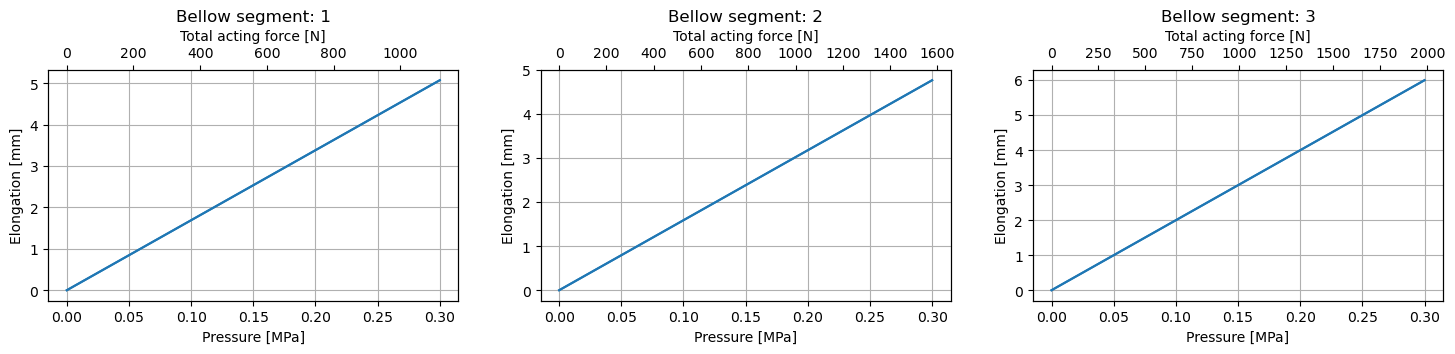

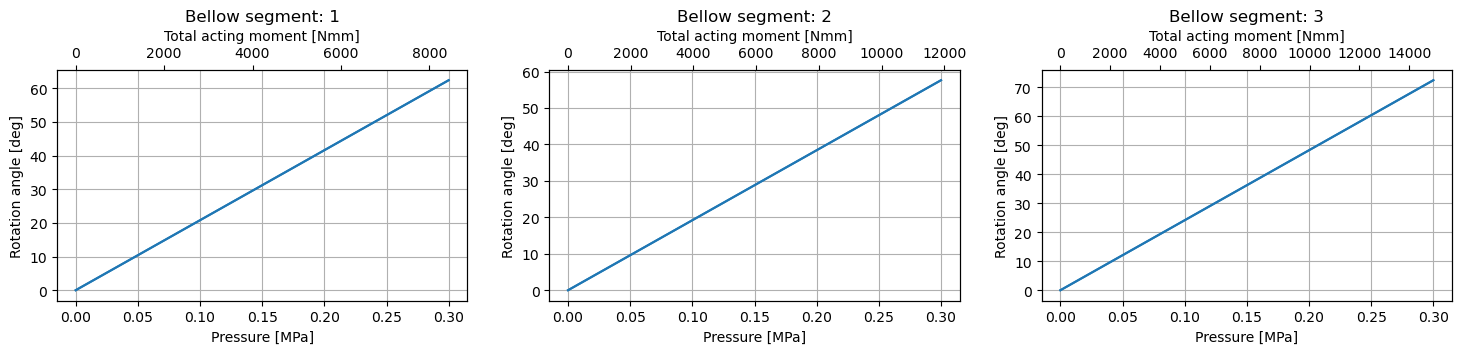

In [8]:
delta_z = F_bellow / Cz[:, np.newaxis] 
# Torsional spring constant - for end moment gamma_pivot * K_theta = c_theta
K = c_theta * E * I_total / L0
print(K)
# Calculate pivot angle
delta_theta_pivot = M_bellow / K[:, np.newaxis]
# Calculate angle displacement
delta_theta_y = delta_theta_pivot * c_theta
# All angular deformations for subsequent segments are culumative sum cross columns
delta_theta_y_cum = np.cumsum(delta_theta_y, axis=0)

# Plot all elongations vs input pressure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
for i in range(3):
    ax[i].plot(pressure, delta_z[i, :])
    ax[i].set_xlabel('Pressure [MPa]')
    ax[i].set_ylabel('Elongation [mm]')
    ax[i].set_title(f'Bellow segment: {i+1}')
    # Add twin x axis showing input force
    ax2 = ax[i].twiny()
    ax2.plot(F_bellow[i, :], delta_z[i, :])
    ax2.set_xlabel('Total acting force [N]')
    ax[i].grid()

# Plot all rotation angles ve input pressure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
for i in range(3):
    ax[i].plot(pressure, delta_theta_y[i, :] * 180 / np.pi)
    ax[i].set_xlabel('Pressure [MPa]')
    ax[i].set_ylabel('Rotation angle [deg]')
    ax[i].set_title(f'Bellow segment: {i+1}')
    # Add twin x axis showing imput moment
    ax2 = ax[i].twiny()
    ax2.plot(M_bellow[i, :], delta_theta_y[i, :] * 180 / np.pi)
    ax2.set_xlabel('Total acting moment [Nmm]')
    ax[i].grid()

In [15]:
print(delta_theta_y * 180 / np.pi)
print(delta_theta_y_cum * 180 / np.pi)
print(delta_z)

[[ 0.          9.24532445 18.4906489  27.73597335 36.9812978  46.22662225
  55.4719467  64.71727115]
 [ 0.          8.35598281 16.71196562 25.06794843 33.42393124 41.77991406
  50.13589687 58.49187968]
 [ 0.         11.37342105 22.7468421  34.12026315 45.49368419 56.86710524
  68.24052629 79.61394734]]
[[  0.           9.24532445  18.4906489   27.73597335  36.9812978
   46.22662225  55.4719467   64.71727115]
 [  0.          17.60130726  35.20261452  52.80392178  70.40522905
   88.00653631 105.60784357 123.20915083]
 [  0.          28.97472831  57.94945662  86.92418493 115.89891324
  144.87364155 173.84836986 202.82309817]]
[[0.         0.49797551 0.99595103 1.49392654 1.99190206 2.48987757
  2.98785308 3.4858286 ]
 [0.         0.33463117 0.66926235 1.00389352 1.3385247  1.67315587
  2.00778704 2.34241822]
 [0.         0.45547021 0.91094042 1.36641063 1.82188084 2.27735105
  2.73282125 3.18829146]]


(0.0, 32.0)

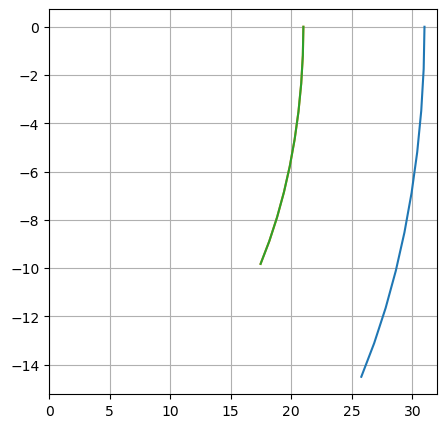

In [ ]:
# Error less than 0.5% in tip deflection up to angular deflection of theta_0max = 124.4 deg
# Characteristic Radius Factor
gamma_pivot = 0.7346
# Parametric angle coefficient
c_theta = 1.5164
# Stiffness coefficient
K_theta = 2.0643
# Torsional spring constant - for end moment gamma_pivot * K_theta = c_theta
K = c_theta * E * I_total / L0

theta_pivot = np.linspace(0, 60, 10)[:, np.newaxis] / c_theta

a = L0 * (1 - gamma_pivot * (1 - np.cos(theta_pivot / 180 * np.pi)))
b = gamma_pivot * L0 * np.sin(theta_pivot / 180 * np.pi)
a, b